# Libaries to import 

In [1]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from error_coding import *
from to_import import *

# Transmitsion
### Importing data, preparing them into the relevant formats, and saving/playing the output .wav file

In [2]:
# Load data here

# Random bits 
CE_binary = binaryTextFileToBinary('Data_Files/random_bits.txt')

# Original binary file
binary = binaryTextFileToBinary('Data_Files/kokoro_bin.txt')

In [3]:
# Add metadata here
data_byte_length = int(len(binary)/8)
file_name = "grp1_test.txt"

line = file_name+str(data_byte_length)
metadata = '0' + bin(int.from_bytes(line.encode(), 'big'))[2:]
metadata = metadata[:len(file_name)*8] + '00000000' + metadata[len(file_name)*8:] + '00000000'

binary = metadata+binary

In [4]:
# Error coding here

# Original binary file passed through Hamming(7,4) coding
#coded_binary = binaryTextFileToBinary('Data_Files/coded_kokoro_bin.txt')

In [5]:
# Set the parameters for transmission
Mode = "B" # select mode from A, B, C

# Cyclic Prefix
CP_mode = {"A": 224, "B": 704, "C": 1184}

# DFT length 
N = 4096
CP = CP_mode[Mode]

# Number of time indecies we go back in time from the "optimal point"
guard = 20

# Number of known symbol repeats for every frame
CE_repeat = 20

# Number of data symbols in each frame
frame_data_length = 180

In [6]:
# Make your instructions ( THIS CAN BE MADE MORE COMPLICATED USING MAGNITUDE DATA FROM THE CHANNEL TF )
instruction = []
for i in range(int(N/2 - 1)):
    if i <1500 and i >= 100:
        instruction.append(1)
    else: 
        instruction.append(0)
        
# assuming 0 -> no data, 1 -> QPSK, 2 -> 16QAM
# find number of bits necessary for each OFDM symbol 
bits_in_ofdm_symbol = 0
for value in instruction: 
    bits_in_ofdm_symbol += value*2

In [7]:
# XOR operation

# This is information shared to the receiver
rand_binary = CE_binary[:bits_in_ofdm_symbol]  
data_binary_len = len(binary)

# Not shared to receiver
rand_for_xor = (rand_binary * math.ceil(data_binary_len/bits_in_ofdm_symbol))[0:data_binary_len]

# XOR the coded binary sequence
coded_binary = xor(binary, rand_for_xor)

In [8]:
# QAM modulation for the coded binary sequence

# Modulate the random sequence used for channel estimation using QPSK
# the first one uses all bins for known data
# the second one only uses the bins that contain data even for known data 
CE_modulated = qpsk(CE_binary)
#CE_modulated = varyingModulation_std(CE_binary, instruction, N, CE_binary, print_progress = True, max_odfm_symbol =1)

# Modulate the data symbols using the instruction array
data_modulated = varyingModulation_std(coded_binary, instruction, N, CE_binary, print_progress = True)

bitcount 2800
additional  2792
data length  3189208
new data len  3192000
symbol number 100 is done.
symbol number 200 is done.
symbol number 300 is done.
symbol number 400 is done.
symbol number 500 is done.
symbol number 600 is done.
symbol number 700 is done.
symbol number 800 is done.
symbol number 900 is done.
symbol number 1000 is done.
symbol number 1100 is done.


In [9]:
# Chirp signal 
Start_F = 0
End_F = 8000
Time = 5*(CP+N)/fs

# Prepare chirp signal
chirp_signal = Chirp(Start_F,End_F,Time, volume = 100)

In [10]:
# For channel esimation (CE)

# Prepare CE and payload data to be transmitted
CE_symbols, CE_Freq = ofdmSymbols(CE_modulated, CP, N)
Payload_symbols, Payload_Freq = ofdmSymbols(data_modulated, CP, N)

# Adjust the number of OFDM symbols in the payload so it has intger number of frame content
extra = frame_data_length - len(Payload_symbols)%frame_data_length
for i in range(extra):
    Payload_symbols = np.concatenate((Payload_symbols, [CE_symbols[1]]))
    

# Identify number of frames are present in the transmitted sequence
num_of_frames = int(len(Payload_symbols)/frame_data_length)

In [11]:
# Prepare what to actually transmit

# Channel estimation at the beginning
CE_transmit = repeat_signal(CE_symbols[0], CE_repeat)
known_freq = CE_Freq[0]

# Payload mixed with CE symbols distributed between them
Payload = prepare_payload_std(Payload_symbols, CE_transmit, chirp_signal, num_of_frames, frame_data_length)

In [13]:
Tx = (Pause(20),) + tuple(Payload) # Pause 20 is just to remove any effects a the beginning of the transmission 
Transmit_time = round(len(np.concatenate(Tx))/fs, 2)

print("Transmit signal is", math.floor(Transmit_time/60), "min and", Transmit_time%60, "seconds")

Transmit signal is 2 min and 57.5 seconds


In [72]:
# Transmit the message / save the wav file
# playOutput = True to play the wave file 
x = save_transmit( Tx , playOutput=True)

playing
[0, 1]
[    0     0     0 ... -8714  5897   935]


# Receiver

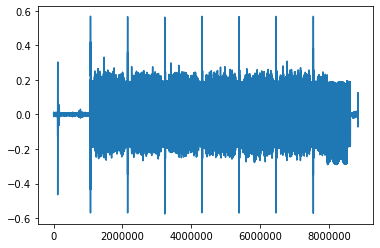

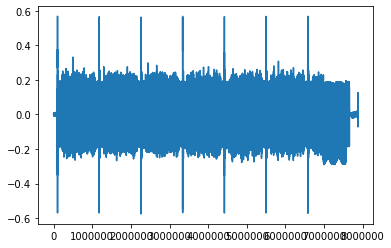

In [73]:
# Import the recorded signal
y = audioDataFromFile('Wav_Files/recording.wav')

# Find the first chirp and return the signal from just before that chirp
y_signal = detect_chirps(y, chirp_signal, 60)

plot_y(y)
plot_y(y_signal, f =1)

In [74]:
# length of each frame in time steps
length = (N + CP) * (frame_data_length + CE_repeat * 2) + len(chirp_signal)
frame_count = count_frames(y_signal, chirp_signal, length)
print("number of frames should be ", frame_count)

number of frames should be  7


Completed frame 1
   Linear phase gradient was  -0.006014462094763104
Completed frame 2
   Linear phase gradient was  -0.005762123098503742
Completed frame 3
   Linear phase gradient was  -0.005612622662094763
Completed frame 4
   Linear phase gradient was  -0.005533023721945129
Completed frame 5
   Linear phase gradient was  -0.005491761658354116
Completed frame 6
   Linear phase gradient was  -0.0053428676745635876


/Users/kaijunge/Documents/University/Year 3/GF3/CleanNoise_GF3/to_import.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(f)
/Users/kaijunge/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Completed frame 7
   Linear phase gradient was  -0.005230893516209477
Data slicing complete


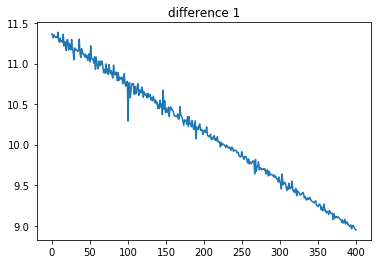

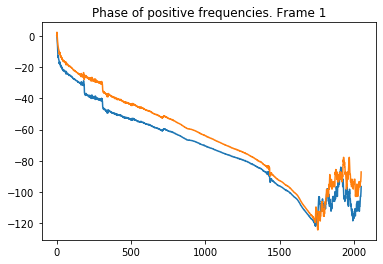

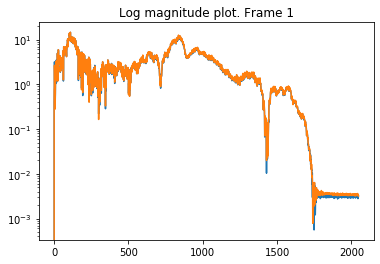

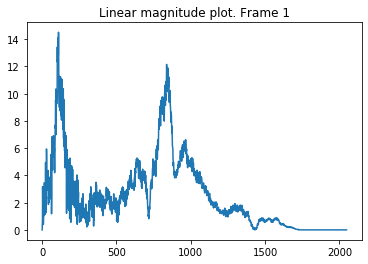

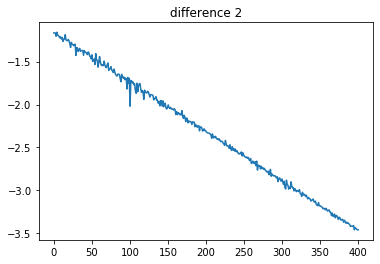

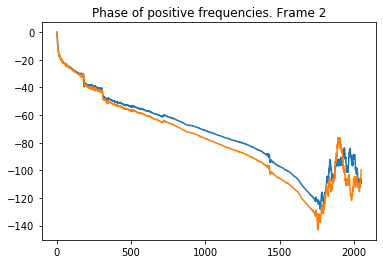

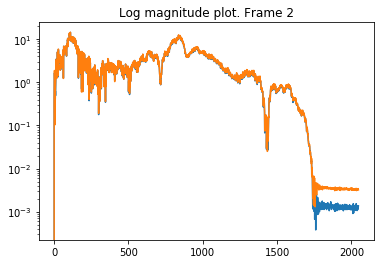

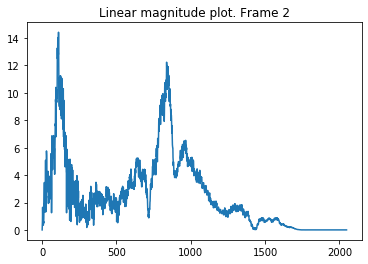

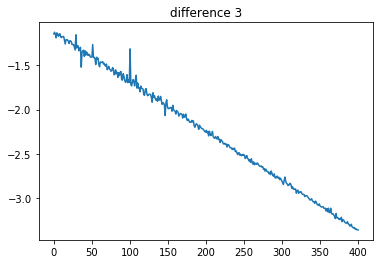

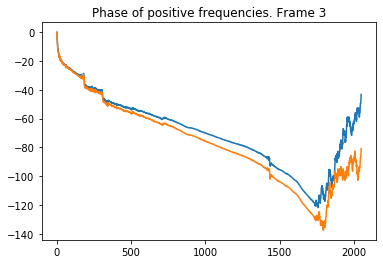

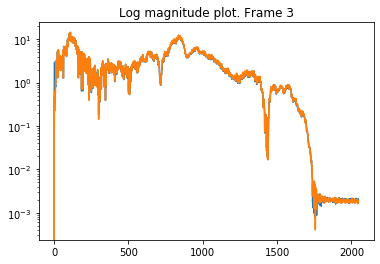

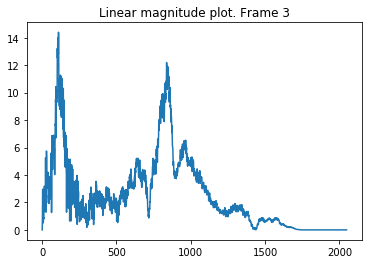

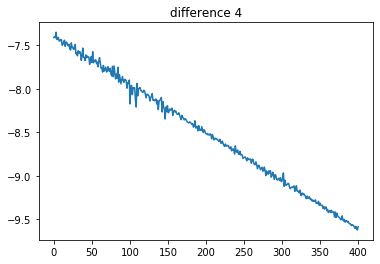

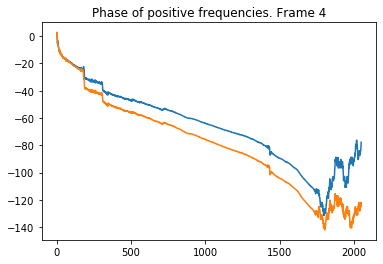

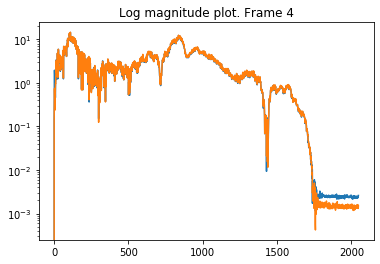

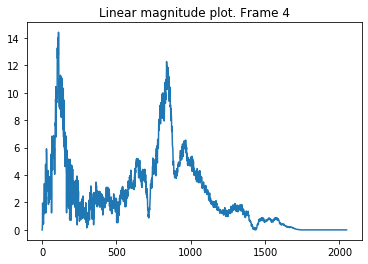

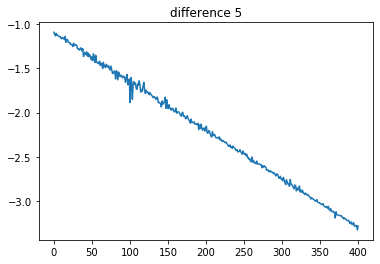

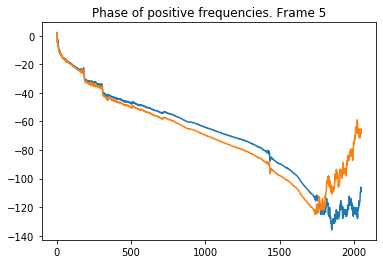

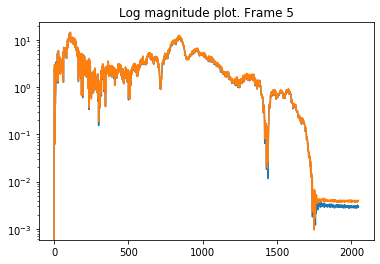

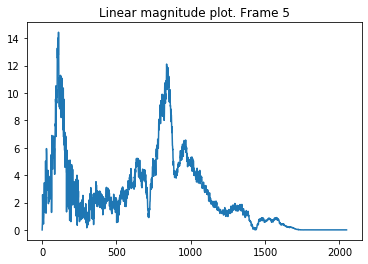

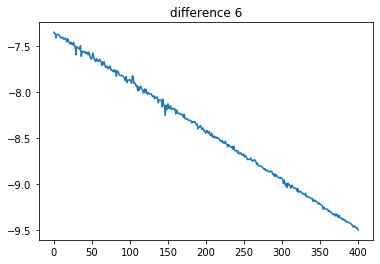

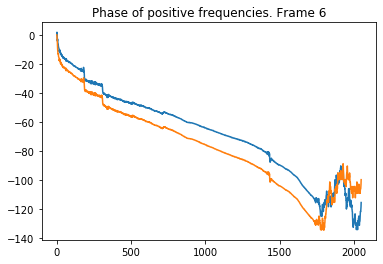

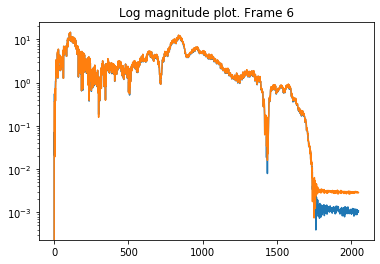

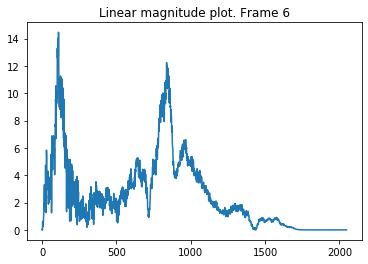

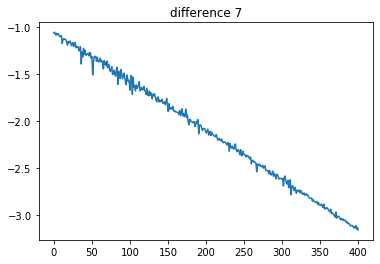

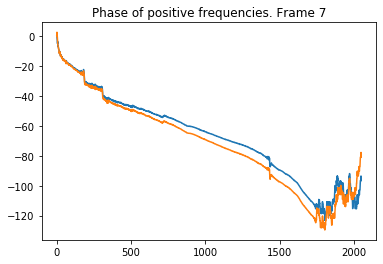

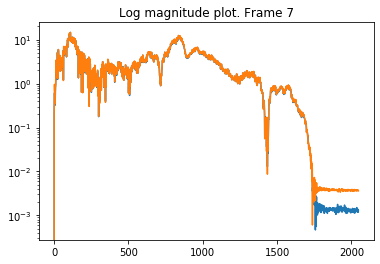

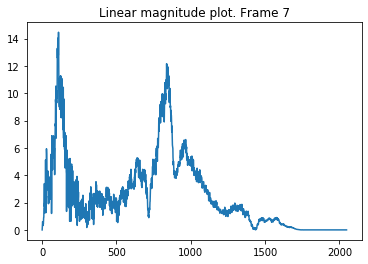

In [75]:
#################################################################################################
# TUNABLE PARAMETERS!
#################################################################################################

stable_phase_start = 200     # where we estimate the "stable region" of the phase to start
stable_phase_length = 400    # how long the stable region continues for
plot = True                # display plots or not

#################################################################################################


# Calculating time index lengths
data_index_length = frame_data_length * (N+CP)
CE_index_length = CE_repeat * (N+CP)


y_use = y_signal
# big loop to find out everything
for i in range(frame_count):
    
    # obtain only the time series for one frame
    y_data = removeChirpAndPause_std(y_use, chirp_signal, fs*6, plot = False, rng = 100)
    


    # Slice the data to retrieve the CE
    CE_samples, CE_freq, remaining = sliceData(y_data, CP-guard, N, CP, CE_repeat)
    CE_samples_end, CE_freq_end, remaining_end \
                    = sliceData(y_data[data_index_length + CE_index_length:], CP-guard, N, CP, CE_repeat)
    
    
    # Obtain channel response at the beginning and end of the frame
    # channel response -> Impulse response and Frequency response (Transfer function)
    impulse_start, TF_start = getTF_FreqAverage(CE_freq, known_freq, N, CE_repeat)
    impulse_end, TF_end = getTF_FreqAverage(CE_freq_end, known_freq, N, CE_repeat)


    # Unwrapped phase for positive frequencies of the channel response
    angle_start = np.unwrap(np.angle(TF_start[:2048]))
    angle_end = np.unwrap(np.angle(TF_end[:2048]))

    # Difference in phase 
    difference = []
    for p, val in enumerate(angle_end):
        difference.append(round(val - angle_start[p], 3))
        
    # p = x coordinates, q = y coordinates to do linear curve fitting
    p = np.linspace(stable_phase_start,   stable_phase_start + stable_phase_length,   stable_phase_length)
    q = difference[stable_phase_start:   stable_phase_start + stable_phase_length  ]
    
    # output gradient and y-intercept. 
    param = np.polyfit(p,q,1)
    grad = param[0]
    
    # Organise all the data symbols in the frame into chunks of 2047 frequency bins
    # Also perform phase correction using the gradient of the linear phase added due to the frequency mismatch
    sliced_data = sliceDataContent_std(TF_start, TF_end, remaining, CP-guard, N, CP, frame_data_length, grad, CE_repeat)
    if i == 0:
        freq_data = sliced_data
    else:
        freq_data = np.concatenate((freq_data, sliced_data))
    
    
    # Update the time domain signal for the next frame
    y_use = remaining_end
    
    
    print("Completed frame " + str(i+1))
    print("   Linear phase gradient was ", grad)
    
    
    # plotting stuff for debug purposes
    if plot:  

        plot_y(difference[stable_phase_start:stable_phase_length + stable_phase_start], f = i+100, title = "difference " + str(i+1))
        plot_y(angle_start, f = i, title = "Phase of positive frequencies. Frame " + str(i+1))
        plot_y(angle_end, f= i)

        plt.figure(i+1000)
        plt.yscale("log")
        plt.plot(abs(np.array(TF_start))[:2048])
        plt.plot(abs(np.array(TF_end))[:2048])
        plt.title("Log magnitude plot. Frame " + str(i+1))
        plot_y(abs(np.array(TF_start))[:2048], f=i+2000, title = "Linear magnitude plot. Frame " + str(i+1)) 
     


print("Data slicing complete")

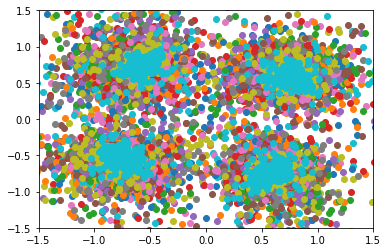

In [86]:
# Plot constellations to see if they are sensible. 


# Set which OFDM symbol to view
start = 10
duration = 40

# display window size
window = 1.5

for i in range(duration):
    
    plot_res = np.array(freq_data[start+i])[100:1500]
    plt.scatter(plot_res.real, plot_res.imag)
    plt.xlim(-1*window,window)
    plt.ylim(-1*window, window)



In [76]:
demodulated_data = demodVaryingModulation_std(np.concatenate(tuple(freq_data)), instruction, N)

# This is information shared to the receiver
data_binary_len = len(demodulated_data)

# What to xor with the data. rand_binary calculated in Transmission side. 
rand_for_xor_Rx = (rand_binary * math.ceil(data_binary_len/bits_in_ofdm_symbol))[0:data_binary_len]


In [77]:
# XOR the whole sequence
predict = xor(demodulated_data, rand_for_xor_Rx)

In [78]:
print(predict[:200])

01100111011100100111000000110001010111110111010001100101011100110111010000101110011101000111100001110100000000000011001100111001001110000011011000110011001100000000000001010000011000010011001001110100


In [79]:
# Here is where you would apply demodulation for any coding. Perhaps for LDPC code you won't need to apply XOR

In [80]:
def remove_metadata(binary_recovered):
# Find information about the file name and the byte length of the file
    file_seperation = []
    count = 0
    for i in range(1000):
        byte = binary_recovered[i*8:(i+1)*8]
        zero = True
        for bit in byte:
            if bit == '1':
                zero = False

        if zero:
            file_seperation.append(i*8)

            count += 1

        if count == 2:
            break

    # Extract file name and length of the file
    Filename= str_to_bytearray(binary_recovered[0:file_seperation[0]]).decode("utf-8", "replace")
    Length =  int(str_to_bytearray(binary_recovered[file_seperation[0]+8:file_seperation[1]]).decode("utf-8", "replace"))

    extra_bits = len(binary_recovered) - file_seperation[1] - 8 - Length*8

    raw_file = binary_recovered[file_seperation[1] + 8 : -1*extra_bits]
    
    return Filename, Length, raw_file

In [85]:
Filename, Length, data_bits = remove_metadata(predict)
print(Filename, Length)

grp1_test.txt 398630


In [82]:
# If it is NOT text, don't include .decode('utf-8', 'replace')
decoded = str_to_bytearray(data_bits).decode('utf-8', 'replace')

In [83]:
decoded

'Pa2t 1: Sensgi and I\x00   I ALWAQS calle` jim "Sensei." [note1] I shall therefore refer to him simply as "Sensei," and not by his real name. It is not because I consider it more discreet, but it is because I find it more natural that I do so. Whenever the memory of him comes back to me now, I find that I think o� him as "Sensei" still. And with pen i. �and, I aannot briNg myselg)qo write \x7ff him in any other way.  It was at Kamakura, during the summer holidays, that I first met Sensei. I was then a very young student. I went there at the insistence of a friend of mine, who had gone to Kamakura to swim. We were not together for long. It had taken me a few d!yS to get together enough money to cnv%r�the necessary$expenses- aod.it was only three days after my arrival that my briend received a telegram from home demanding his return. His mother, the telegram explained, was ill. My friend, however, did not believe this. For some time his parents had been trying to persuade him, much agai

In [84]:
correct = 0
max_index = min(len(predict), len(binary))
for i in range(max_index):
    if predict[i] == binary[i]:
        correct += 1
        
print(correct/max_index)

0.9963849958986682
